In [13]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [14]:
'''
Importing California SNG
'''

graph = src.graph.graph_from_json('Outputs/graph_full_tesla.json')
graph = nx.DiGraph(graph)

In [15]:
places = [k for k, v in graph._node.items() if v['type'] == 'place']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

graph_places = src.graph.subgraph(graph, places)

node_to_idx = {k: idx for idx, k in enumerate(graph_places.nodes)}
idx_to_node = {idx: k for idx, k in enumerate(graph_places.nodes)}

In [24]:
vehicle_kw = {
    'capacity': 381 * 3.6e6,
    'power': 14.15e6,
    'risk_attitude': [.4, .6],
    'cases': 1,
    'soc_bounds': (.1, 1),
    'linear_fraction': 1.,
}

station_kw = {
    'place': {
        'cases': 30,
        'type': 'ac',
        'power': 14.15e6,
        'access': 'private',
        'setup_time': 300,
    },
    'station': {
        'cases': 30,
        'type': 'ac',
        'power': 14.15e6,
        'access': 'private',
        'setup_time': 300,
    },
}

In [25]:
deep_reload(src)

t0 = time.time()

costs, values, paths = src.experiments.run_case(
    graph,
    vehicle_kw,
    station_kw,
)

out_arrays = src.analysis.values_to_array(
    places, values, ['total_time', 'driving_time', 'charge_event']
)

visits = src.analysis.nodes_visited(
    graph.nodes, paths,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 4.5848 seconds


In [26]:
paths['San Diego']['Crescent City']

['San Diego', 'station_229', 'Crescent City']

In [27]:
values['San Diego']['Crescent City']['total_time'] / 3600

13.553109459435337

In [28]:
values['San Diego']['Crescent City']['driving_time'] / 3600

13.37173358585858

In [29]:
graph['San Diego']['station_229'], graph['station_229']['Crescent City']

({'time': 25559.590909090894,
  'distance': 740470.0,
  'price': 0,
  'effective_distance': 745340.0,
  'feasible': True,
  'energy': 409937000.0,
  'charging_time': 28.97081272084806,
  'delay_time': 300.0,
  'driving_time': 25559.590909090894,
  'total_time': 25888.56172181174,
  'routing_time': 25888.56172181174,
  'charge_event': 1},
 {'time': 22578.649999999998,
  'distance': 617000.0,
  'price': 0,
  'effective_distance': 617000.0,
  'feasible': True,
  'energy': 339350000.0,
  'charging_time': 23.982332155477028,
  'delay_time': 300.0,
  'driving_time': 22578.649999999998,
  'total_time': 22902.632332155474,
  'routing_time': 22902.632332155474,
  'charge_event': 1})

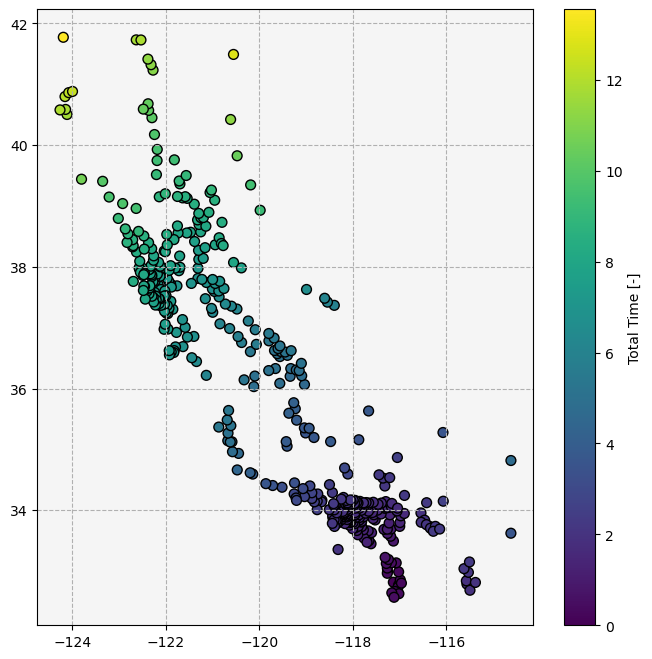

In [31]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

origin = 'San Diego'

for source, node in graph_places._node.items():

    arc = values[origin].get(source, {})

    node['plot'] = (
        arc.get('routing_time', np.nan) - arc.get('driving_time', np.nan)
    )/ 3600

    node['plot'] = (
        arc.get('total_time', np.nan)
    )/ 3600

    # node['plot'] = arc.get('charge_event', np.nan)

kw = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Total Time [-]',
    },
}

src.figures.plot_graph(
   graph_places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

0.1261196608908569


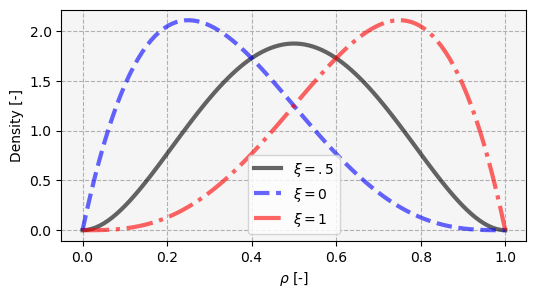

In [48]:
from scipy.stats import beta
import matplotlib.patheffects as pe

a = [2, 4]
b = [4, 2]

r = np.random.rand()

dist = beta(np.interp(r, [0, 1], a), np.interp(r, [0, 1], np.flip(a)))
print(r)

# x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
x = np.linspace(0, 1, 100)

cs = src.figures.colormap('plasma')

fig, ax = plt.subplots(1, 1, figsize = (6, 3))

ax.plot(
    x, beta.pdf(x, 3, 3),
    ls = '-',  lw = 3, alpha=0.6, label = r'$\xi = .5$',
    # path_effects=[pe.Stroke(linewidth=5, foreground='g'), pe.Normal()],
    # color = '#22695e',
    color = 'k',
)
ax.plot(
    x, beta.pdf(x, 2, 4),
    ls = '--', lw = 3, alpha=0.6, label = r'$\xi = 0$',
    # path_effects=[pe.Stroke(linewidth=7, backgorund='k'), pe.Normal()],
    # color = '#add51f',
    color = 'b',
)
ax.plot(
    x, beta.pdf(x, 4, 2),
    ls = '-.', lw = 3, alpha=0.6, label = r'$\xi = 1$',
    # color = '#8270f6',
    color = 'r',
)
# ax.plot(x, dist.pdf(x),'g-', lw=5, alpha=0.6, label='beta pdf')

ax.legend()

kw = {
    'facecolor': 'whitesmoke',
    'xlabel': r'$\rho$ [-]',
    'ylabel': 'Density [-]',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

fig.savefig('Paper/figs/rho_distributions.png', bbox_inches = 'tight', dpi = 300)

In [244]:
places = [k for k, v in graph._node.items() if v['type'] == 'place']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

graph_places = src.graph.subgraph(graph, places)
# graph_stations = src.graph.subgraph(graph, stations)

In [245]:
graph.is_directed(), graph.number_of_edges()

(True, 732844)

In [263]:
'''
Next step is to define vehicle andsupply station objects.
These objects will be used to add supply costs to edges which begin at a supply station.
'''
deep_reload(src)

seed = 1468952
# seed = None
rng = np.random.default_rng(seed)

risk_attitude = (0, .2)
risk_attitude = (.8, 1)
rho = np.linspace(*risk_attitude, 100)

cases = 30

station_kw = {}

station_kw['place'] = {
    'cases': 1,
    'type': 'ac',
    'access': 'private',
    'price': .4 / 3.6e6,
    'setup_time': 0,
    'rng': rng,
    'power': np.inf,
}

station_kw['station'] = {
    'reliability': .5,
    'cases': cases,
    'type': 'dc',
    'access': 'public',
    'power': src.routing._network_power,
    'price': .5 / 3.6e6,
    'setup_time': 300,
    'rng': rng,
    'traffic': 1,
}

vehicle_kw = {
    'cases': 1,
    'linear_fraction': .8,
    'risk_attitude': (0, 1),
    # 'max_charge_start_soc': .8,
}

t0 = time.time()

vehicle = src.routing.Vehicle(**vehicle_kw)

graph = src.routing.supply_costs(graph, vehicle, station_kw)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 8.8606 seconds


In [253]:
# graph._adj['station_10']

In [264]:
deep_reload(src)

places = [k for k, v in graph._node.items() if v['type'] == 'place']
stations = [k for k, v in graph._node.items() if v['type'] == 'station']

t0 = time.time()

costs, values, paths = src.floyd_warshall.floyd_warshall(
    graph,
    fields = ['routing_time', 'total_time', 'driving_time', 'distance', 'charge_event'],
    origins = places,
    destinations = places,
    pivots = stations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 4.5065 seconds


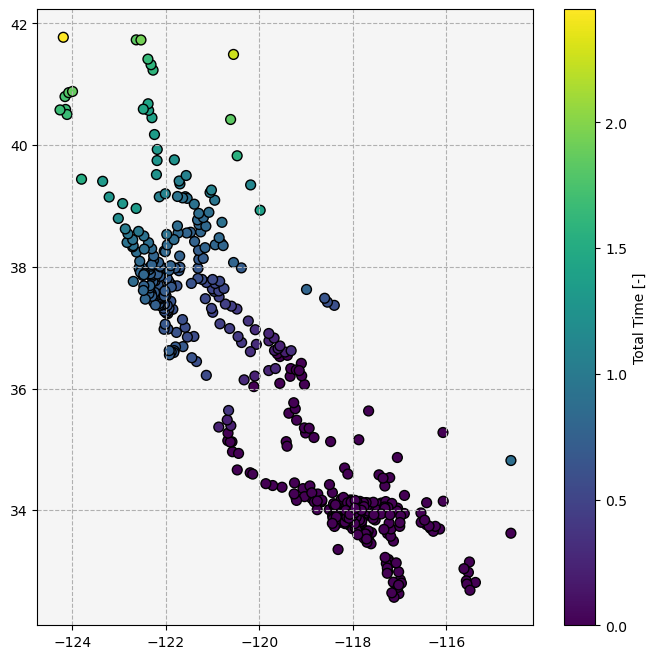

In [265]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

origin = 'San Diego'

for source, node in graph_places._node.items():

    arc = values[origin].get(source, {})

    node['plot'] = (
        arc.get('routing_time', np.nan) - arc.get('driving_time', np.nan)
    )/ 3600

    # node['plot'] = arc.get('charge_event', np.nan)

kw = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Total Time [-]',
    },
}

src.figures.plot_graph(
   graph_places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

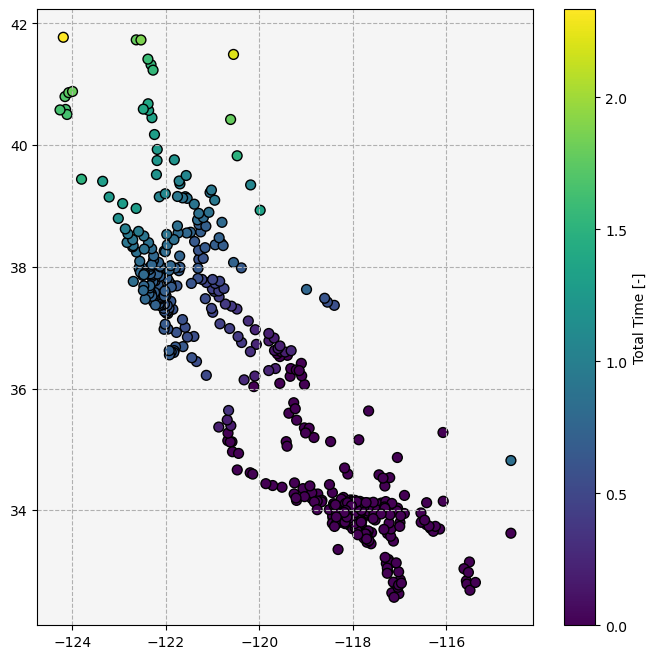

In [251]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

origin = 'San Diego'

for source, node in graph_places._node.items():

    arc = values[origin].get(source, {})

    node['plot'] = (
        arc.get('routing_time', np.nan) - arc.get('driving_time', np.nan)
    )/ 3600

    # node['plot'] = arc.get('charge_event', np.nan)

kw = {
    'show_links': False,
    'node_field': 'plot',
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': 'Total Time [-]',
    },
}

src.figures.plot_graph(
   graph_places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

In [42]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [43]:
atlas = src.graph.graph_from_json('atlas.json')

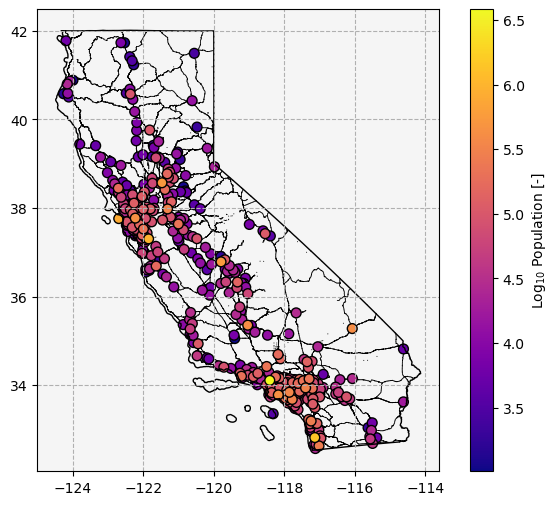

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

origin = 'San Diego'

for source, node in graph_places._node.items():

    # arc = values[origin].get(source, {})

    # node['plot'] = (
    #     arc.get('routing_time', np.nan) - arc.get('time', np.nan)
    # )/ 3600

    node['plot'] = np.log10(node['population'])

kw = {
    'show_links': False,
    'node_field': 'plot',
    'cmap': src.figures.colormap('plasma'),
    'scatter': {
        's': 50,
        'ec': 'k',
        'zorder': 0,
        'label': 'Stations',
    },
    'colorbar': {
        'label': r'Log$_{10}$ Population [-]',
    },
}

src.figures.plot_graph(
   graph_places, ax = ax, **kw,
)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

fig.savefig('Paper/figs/california_incorporated_places.png', bbox_inches = 'tight', dpi = 300)